In [1]:
# User defined variables
my_training_state = 'MN' # State USPS abbreviation
state_name = 'Minnesota'
my_nas_id = 5
nas_name = 'zm'
# IA = 19; ID = 16; IL = 17; MN = 27; MO = 29; MT = 30; OR = 41;  WA = 53; WI = 55
state_fips = '27'
state_fip = 'US%3A'+ state_fips # Replace last 2 digits with your state's FIP code
my_path = 'data/' + my_training_state + '/' # leave this alone 
my_crs = "EPSG:5070"

In [2]:
import os
import json
import glob
import zipfile
import random
import io
from io import StringIO, BytesIO
from tqdm import tqdm

# Data Handling
import pandas as pd
import numpy as np
import geopandas as gpd

import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize
from rasterio.mask import mask
import rasterio.plot
from rasterio.warp import calculate_default_transform, reproject, Resampling
from affine import Affine
import networkx as nx
from shapely.geometry import Point, LineString, MultiLineString
from shapely.ops import snap, nearest_points
from rasterio.transform import from_bounds
from shapely.geometry import box
from shapely.ops import unary_union
from rasterio.merge import merge
from rasterio.errors import RasterioIOError
from joblib import Parallel, delayed
# Machine Learning & Statistical Modeling
import sklearn as skl
from sklearn.neighbors import KDTree, KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn import gaussian_process

# Geostatistics & Interpolation
import skgstat as skg
import gstools as gs
from skgstat import models
from skgstat.util.likelihood import get_likelihood
import scipy
from scipy.spatial.distance import pdist
from scipy.spatial import distance_matrix
from scipy.optimize import minimize
from scipy.spatial import cKDTree
from scipy.interpolate import NearestNDInterpolator
import scipy.ndimage
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

# Visualization
import matplotlib.pyplot as plt

# APIs & Requests
import requests
from pygbif import occurrences as occ
from pygbif import species
from shapely import union_all
from tqdm import tqdm
from joblib import Parallel, delayed
from contextlib import contextmanager
import joblib
from collections import defaultdict

In [3]:
#Helper functions for water chemistry interpolation and biodiversity predictors
def get_station_data(state):
    URL_BASE_2 = 'https://www.waterqualitydata.us/data/Station/search?'
    url_request_2 = f"{URL_BASE_2}countrycode=US&statecode={state}"
    response_2 = pd.read_csv(url_request_2)
    return response_2
def find_nearest(row, other_gdf):
    # Find the index of the nearest geometry
    nearest_idx = other_gdf.distance(row.geometry).idxmin()
    return other_gdf.loc[nearest_idx]
def add_nearest(gdf1, gdf2):
    nearest_neighbors = gdf1.apply(lambda row: find_nearest(row, gdf2), axis=1)
    # Add nearest neighbor information to the first GeoDataFrame
    gdf1['nearest_id'] = nearest_neighbors['station_id']
    gdf1['median'] = nearest_neighbors['median']
    parameter_added = gdf1
    return parameter_added
def get_data(state, characteristic, my_format):
    URL_BASE = 'https://www.waterqualitydata.us/data/Result/search?'
    url_request = f"{URL_BASE}countrycode=US&statecode={state}&characteristicName={characteristic}&mimeType={my_format}"
    response = pd.read_csv(url_request)
    return response


In [ ]:
# Download state boundaries shapefile
state_boundary_url = 'http://www2.census.gov/geo/tiger/TIGER2012/STATE/tl_2012_us_state.zip'
local_path = my_path
print('Downloading shapefile...')
r = requests.get(state_boundary_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")
z.extractall(path=local_path) # extract to folder
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)
# Get USGS monitoring stations from their API
my_stations = get_station_data(state = state_fip)
#Filter and convert to a Geodataframe
stations = my_stations[['MonitoringLocationIdentifier', 'LatitudeMeasure', 'LongitudeMeasure']].rename(columns = {'MonitoringLocationIdentifier': 'station_id',
                        'LatitudeMeasure' : 'latitude', 'LongitudeMeasure' : 'longitude'})  
stations_gdf = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations.longitude, stations.latitude),
    crs="EPSG:4326"  # WGS84 for raw lat/lon
).to_crs("EPSG:5070")
stations_gdf.to_file(my_path + 'usgs_monitoring_stations.shp') # Saving and importing saved files later allows you to import later without remaking variables
print('Station and State data saved')


In [4]:
stations_gdf = gpd.read_file(my_path + 'usgs_monitoring_stations.shp').to_crs("EPSG:5070")
state_boundary = gpd.read_file(my_path + 'tl_2012_us_state.shp').to_crs("EPSG:5070")

# Filter to the boundary of the selected state
state = state_boundary.loc[state_boundary['STUSPS'] == my_training_state]

# Ensure both GeoDataFrames are in the same CRS
stations_gdf = stations_gdf.to_crs(state.crs)

# Spatial join to find stations within the state
my_training_state_stations = gpd.sjoin(
    stations_gdf, state, how="inner", predicate="within")


In [ ]:
ca = get_data(state = state_fip, my_format = 'csv', characteristic = 'Calcium')
ca_resultsFile = pd.DataFrame(ca).dropna(subset=['ResultMeasureValue'])
ca_resultsFile.ResultMeasureValue = pd.to_numeric(ca_resultsFile.ResultMeasureValue, errors='coerce')
ca_fixed = ca_resultsFile[['CharacteristicName', 'ActivityStartDate', 'MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode']].rename(columns={"CharacteristicName": "Characteristic", "ActivityStartDate": "date", 'MonitoringLocationIdentifier' : "station_id", 'ResultMeasureValue' : "value", 'ResultMeasure/MeasureUnitCode': "unit"})
# Change units for those that are equivalent to mg/L and make ug/L units consistent
ca_clean_1 = ca_fixed.replace({'mg/l' : 'mg/L', 'mg/kg' : 'mg/L', 'mg/l CaCO3': 'mg/L', 'ug/l' : 'ug/L'} )
# convert ug/L to mg/L
ca_clean_1['value'] = ca_clean_1.apply(
    lambda row: row['value'] / 1000 if row['unit'] == 'ug/L' else row['value'],
    axis=1)
#Change unit for converted values to mg/L
ca_clean_2 = ca_clean_1.replace({'ug/L': 'mg/L'})
#Get rid of other records not in mg/L
my_ca = ca_clean_2[ca_clean_2['unit'] == 'mg/L']
#Filter to reasonable values
ca_fixed_2 = my_ca[my_ca['value'] < 300]
ca_fixed_3 = ca_fixed_2[ca_fixed_2['value'] > 0]
#Calculate summary stats by station_id
ca_result = pd.DataFrame(ca_fixed_3.groupby(['station_id'])['value'].aggregate(['median'])).reset_index()
stations_w_ca = pd.merge(my_training_state_stations, ca_result, on = 'station_id').dropna()
ca_station_list = stations_w_ca['station_id'].tolist()
stations_no_ca = my_training_state_stations[~my_training_state_stations['station_id'].isin(ca_station_list)]
ca = add_nearest(stations_no_ca, stations_w_ca)
my_ca_result = pd.concat([ca, stations_w_ca], axis = 0).drop(columns = {"nearest_id","latitude","longitude"})
my_ca_result.to_file(my_path + 'usgs_ca.shp')

In [ ]:
pH = get_data(state = state_fip, my_format = 'csv', characteristic = 'pH')

In [ ]:
pH_resultsFile =pd.DataFrame(pH).dropna(subset=['ResultMeasureValue'])
pH_resultsFile.ResultMeasureValue = pd.to_numeric(pH_resultsFile.ResultMeasureValue, errors='coerce')
pH_fixed = pH_resultsFile[['CharacteristicName', 'ActivityStartDate', 'MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode']].rename(columns={"CharacteristicName": "Characteristic", "ActivityStartDate": "date", 'MonitoringLocationIdentifier' : "station_id", 'ResultMeasureValue' : "value", 'ResultMeasure/MeasureUnitCode': "unit"})
my_pH = pH_fixed.loc[(pH_fixed['unit'].isna()) | (pH_fixed['unit']== 'std units')]
pH_result = pd.DataFrame(my_pH.groupby(['station_id'])['value'].aggregate(['median'])).reset_index()
pH_fixed_2 = pH_result[pH_result['median'] < 14] 
pH_fixed_3 = pH_fixed_2[pH_fixed_2['median'] > 4]
stations_w_pH = pd.merge(my_training_state_stations, pH_fixed_3, on = 'station_id').dropna()
pH_station_list = stations_w_pH['station_id'].tolist()
stations_no_pH = my_training_state_stations[~my_training_state_stations['station_id'].isin(pH_station_list)]
pH = add_nearest(stations_no_pH, stations_w_pH)
my_pH_result = pd.concat([pH, stations_w_pH], axis = 0).drop(columns = {"nearest_id", "latitude", "longitude"})
my_pH_result.to_file(my_path + 'usgs_pH.shp')

In [ ]:
di_N = get_data(state = state_fip, my_format = 'csv', characteristic = 'Nitrogen')

In [ ]:
di_N_resultsFile = pd.DataFrame(di_N).dropna(subset=['ResultMeasureValue'])
di_N_resultsFile.ResultMeasureValue = pd.to_numeric(di_N_resultsFile.ResultMeasureValue, errors='coerce')
di_N_fixed = di_N_resultsFile[['CharacteristicName', 'ActivityStartDate', 'MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode']].rename(columns={"CharacteristicName": "Characteristic", "ActivityStartDate": "date", 'MonitoringLocationIdentifier' : "station_id", 'ResultMeasureValue' : "value", 'ResultMeasure/MeasureUnitCode': "unit"})
di_N_fixed.loc[(di_N_fixed['unit'] == 'ug/L') | 
       (di_N_fixed['unit'] == 'ppb') | (di_N_fixed['unit'] == 'mg/g'), 'value'] /= 1000
di_N_clean_1 = di_N_fixed.replace({'mg/l' : 'mg/L', 'mg/kg' : 'mg/L', 'ppb': 'mg/L', 'ug/L' : 'mg/L'})
di_fixed_2 = di_N_clean_1[di_N_clean_1['unit'] == 'mg/L']
di_fixed_3 = di_fixed_2[di_fixed_2['value']<= 500]
di_fixed_4 = di_fixed_3[di_fixed_3['value'] > 0]
di_N_result = pd.DataFrame(di_fixed_4.groupby(['station_id'])['value'].aggregate(['median'])).reset_index()
stations_w_di_N = pd.merge(my_training_state_stations, di_N_result, on = 'station_id')
di_N_station_list = stations_w_di_N['station_id'].tolist()
stations_no_di_N = my_training_state_stations[~my_training_state_stations['station_id'].isin(di_N_station_list)]
di_N = add_nearest(stations_no_di_N, stations_w_di_N)
my_di_N_result = pd.concat([di_N, stations_w_di_N], axis = 0).drop(columns = {"nearest_id", "latitude","longitude"})
my_di_N_result.to_file(my_path + 'usgs_N.shp')

In [ ]:
do = get_data(state = state_fip, my_format = 'csv', characteristic = 'Oxygen')

In [ ]:
do_resultsFile = pd.DataFrame(do).dropna(subset=['ResultMeasureValue'])
do_resultsFile.ResultMeasureValue = pd.to_numeric(do_resultsFile.ResultMeasureValue, errors='coerce')
do_fixed = do_resultsFile[['CharacteristicName', 'ActivityStartDate', 'MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode']].rename(columns={"CharacteristicName": "Characteristic", "ActivityStartDate": "date", 'MonitoringLocationIdentifier' : "station_id", 'ResultMeasureValue' : "value", 'ResultMeasure/MeasureUnitCode': "unit"})
do_fixed.loc[(do_fixed['unit'] == 'mg/L'), 'value'] *= 12.67
do_clean_1 = do_fixed.replace({'mg/L' : '% saturatn', '% by vol' : '% saturatn'})
do_fixed_2 = do_clean_1[do_clean_1['value']<= 1]
do_fixed_3 = do_fixed_2[do_fixed_2['value']> 0]
do_result = pd.DataFrame(do_fixed_3.groupby(['station_id'])['value'].aggregate(['median'])).reset_index()
stations_w_do = pd.merge(my_training_state_stations, do_result, on = 'station_id')
do_station_list = stations_w_do['station_id'].tolist()
stations_no_do = my_training_state_stations[~my_training_state_stations['station_id'].isin(do_station_list)]
do = add_nearest(stations_no_do, stations_w_do)
my_do_result = pd.concat([do, stations_w_do], axis = 0).drop(columns = {"nearest_id", "latitude","longitude"})
my_do_result.to_file(my_path + 'usgs_do.shp')

In [ ]:
phos = get_data(state = state_fip, my_format = 'csv', characteristic = 'Phosphorus')

In [ ]:
phos_resultsFile = pd.DataFrame(phos).dropna(subset=['ResultMeasureValue'])
phos_resultsFile.ResultMeasureValue = pd.to_numeric(phos_resultsFile.ResultMeasureValue, errors='coerce')
phos_fixed = phos_resultsFile[['CharacteristicName', 'ActivityStartDate', 'MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode']].rename(columns={"CharacteristicName": "Characteristic", "ActivityStartDate": "date", 'MonitoringLocationIdentifier' : "station_id", 'ResultMeasureValue' : "value", 'ResultMeasure/MeasureUnitCode': "unit"})
phos_fixed.loc[(phos_fixed['unit'] == 'ug/L') | 
       (phos_fixed['unit'] == 'ppb') | (phos_fixed['unit'] == 'mg/g'), 'value'] /= 1000
phos_clean_1 = phos_fixed.replace({'mg/l' : 'mg/L', 'mg/l PO4' : 'mg/L', 'mg/l as P' : 'mg/L', 'mg/kg' : 'mg/L', 'mg/kg as P' : 'mg/L',
                                  'ug/L' : 'mg/L', 'ppb' : 'mg/L', 'mg/g' : 'mg/L'} )
my_phos = phos_clean_1[phos_clean_1['unit'] == 'mg/L']
phos_fixed_2 = my_phos[my_phos['value']<= 1]
phos_result = pd.DataFrame(phos_fixed_2.groupby(['station_id'])['value'].aggregate(['median'])).reset_index()
stations_w_phos = pd.merge(my_training_state_stations, phos_result, on = 'station_id')
phos_station_list = stations_w_phos['station_id'].tolist()
stations_no_phos = my_training_state_stations[~my_training_state_stations['station_id'].isin(phos_station_list)]
phos = add_nearest(stations_no_phos, stations_w_phos)
my_phos_result = pd.concat([phos, stations_w_phos], axis = 0).drop(columns = {"nearest_id", "latitude","longitude"})
my_phos_result.to_file(my_path + 'usgs_phos.shp')

In [ ]:
my_ca_result = gpd.read_file(my_path + 'usgs_ca.shp')
my_pH_result = gpd.read_file(my_path + 'usgs_pH.shp')
my_di_N_result = gpd.read_file(my_path + 'usgs_N.shp')
my_do_result = gpd.read_file(my_path + 'usgs_do.shp')
my_phos_result = gpd.read_file(my_path + 'usgs_phos.shp')

In [ ]:
def interpolate(stations_w_data, filename, bandname="Interpolated_Band", max_grid_size=500):
    # Extract coordinates and values
    stations_w_data.set_crs("EPSG:5070")
    stations_w_data['x'] = stations_w_data.geometry.x
    stations_w_data['y'] = stations_w_data.geometry.y
    samples_df = stations_w_data[['x', 'y', 'median']]
    x_point = samples_df['x']
    y_point = samples_df['y']
    coords = np.column_stack((x_point, y_point))
    vals = samples_df['median']
    
    # Scatter plot of original data
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    art = ax.scatter(coords[:, 0], coords[:, 1], s=10, c=vals, cmap='plasma', vmin=0, vmax=vals.max())
    plt.colorbar(art)
    plt.title("Original Data Points")
    plt.show()
    
    # Adaptive grid sizing
    xmin, xmax = x_point.min(), x_point.max()
    ymin, ymax = y_point.min(), y_point.max()
    
    grid_x = min(max_grid_size, int((xmax - xmin) / 500))
    grid_y = min(max_grid_size, int((ymax - ymin) / 500))

    use_kriging = grid_x * grid_y <= 1e6
    
    try:
        if use_kriging:
            print("🔹 Attempting Ordinary Kriging interpolation...")
            
            pairwise_distances = pdist(coords)  # Compute pairwise distances between points
            maxlag = np.median(pairwise_distances)  # Use median distance
            n_lags = min(30, max(10, int(len(coords) / 10)))
            V = skg.Variogram(coords, vals, model='exponential', maxlag=maxlag, n_lags=n_lags, normalize=False)
            ok = skg.OrdinaryKriging(V, min_points=1, max_points=8, mode='exact')
            xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
            field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
            s2 = ok.sigma.reshape(xx.shape)
            print("✅ Kriging completed successfully.")
        else:
            raise MemoryError  
    except (MemoryError, ValueError, np.linalg.LinAlgError):
        print("⚠️ Kriging failed, using Nearest Neighbor interpolation...")
        xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
        knn = KNeighborsRegressor(n_neighbors=min(8, len(coords)), weights='distance', algorithm='kd_tree', n_jobs=-1)
        knn.fit(coords, vals)
        query_points = np.column_stack((xx.ravel(), yy.ravel()))
        field = knn.predict(query_points).reshape(xx.shape)
        s2 = np.zeros_like(field)
        print("✅ Nearest Neighbor interpolation completed.")

    # Fill missing values
    def fill_missing_values(field):
        mask = np.isnan(field)
        if np.all(mask):
            raise ValueError("All values are NaN; interpolation cannot be performed.")
        nearest_indices = scipy.ndimage.distance_transform_edt(mask, return_distances=False, return_indices=True)
        field[mask] = field[tuple(nearest_indices[i][mask] for i in range(field.ndim))]
        return field

    field = fill_missing_values(field)

    # Export interpolated raster
    nrows, ncols = field.shape
    xres = (xmax - xmin) / float(ncols)
    yres = (ymax - ymin) / float(nrows)
    
    arr = np.flipud(np.abs(field.T)).astype(np.float32)
    transform = from_origin(xmin, ymax, xres, yres)  
    
    # Export raster
    with rasterio.open(filename, 'w', driver='GTiff',
                       height=arr.shape[0], width=arr.shape[1],  # Ensure correct height/width order
                       count=1, dtype=str(arr.dtype),
                       crs= "EPSG:5070",
                       transform=transform) as new_dataset:
        new_dataset.write(arr, 1)
        new_dataset.set_band_description(1, bandname)
    
    print(f"✅ Raster saved correctly: {filename}")
    
    # Plot corrected raster
    plt.figure(figsize=(10, 8))
    plt.imshow(arr, extent=[xmin, xmax, ymin, ymax], cmap='plasma', origin="upper")  # Corrected orientation
    plt.colorbar(label=bandname)
    plt.title("Interpolated Raster (Corrected Orientation)")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()


In [ ]:
interpolate(my_ca_result, my_path + my_training_state + '_ca.tif', 'Ca')

In [ ]:
interpolate(my_pH_result, my_path + my_training_state + '_pH.tif', 'pH')

In [ ]:
interpolate(my_di_N_result, my_path + my_training_state + '_di_N.tif', 'Nitrogen')

In [ ]:
interpolate(my_do_result, my_path + my_training_state + '_do.tif', 'DO')

In [ ]:
interpolate(my_phos_result, my_path + my_training_state + '_phos.tif', 'Phos')

In [ ]:
## Note: if you already have these waterbody assets, you don't need to recreate them unless you changed states

# Start of Biological Variables
# Download waterbody shapefiles by state from NHD 
URL_BASE_NHD = 'https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/NHD/State/Shape/'
NHD_url = f"{URL_BASE_NHD}NHD_H_{state_name}_State_Shape.zip"
local_path = my_path
print('Downloading shapefile...')
r = requests.get(NHD_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")
z.extractall(path=local_path) # extract to folder
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)

In [ ]:
# Import stream files, combine into single geodataframe and save for later use
# Find all shapefiles that include "NHDFlowline_" in the filename
shapefiles = glob.glob(os.path.join(my_path + "/shape/", "*NHDFlowline_*.shp")) + glob.glob(os.path.join(my_path + "/shape/", "NHDFlowline.shp"))

# Ensure shapefiles were found
if not shapefiles:
    print("No shapefiles found matching the pattern.")

# Load all shapefiles into a list of GeoDataFrames
gdfs = [gpd.read_file(shp) for shp in shapefiles]

# Optionally, concatenate all shapefiles into a single GeoDataFrame
if gdfs:  # Only concatenate if the list is not empty
    stream_gdf = gpd.pd.concat(gdfs, ignore_index=True)
    print("Successfully merged shapefiles into a single GeoDataFrame.")
else:
    stream_gdf = None
    print("No valid shapefiles to merge.")

# Print summary
print(f"Imported {len(gdfs)} shapefiles")
stream_gdf.to_file(my_path + my_training_state + "_streams.shp")
print(f"Saved combined streams shapefile")

In [ ]:
# Load once, reuse multiple times
streams = gpd.read_file(f"{my_path}{my_training_state}_streams.shp").to_crs("EPSG:5070")
lakes = gpd.read_file(f"{my_path}/shape/NHDWaterbody.shp").to_crs("EPSG:5070")
rivers = gpd.read_file(f"{my_path}/shape/NHDArea.shp").to_crs("EPSG:5070")

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
from shapely.ops import unary_union
from tqdm import tqdm
from joblib import Parallel, delayed
import numpy as np
import warnings

# Use tqdm only in parallel-friendly spots
tqdm.pandas()

def buffer_water_layers(
    streams: gpd.GeoDataFrame,
    lakes: gpd.GeoDataFrame,
    rivers: gpd.GeoDataFrame,
    path: str,
    state_abbr: str,
    simplify_tolerance: float = 100,
    n_jobs: int = -1
) -> tuple[gpd.GeoDataFrame, gpd.GeoDataFrame]:
    crs = "EPSG:5070"

    print(f"[1/9] Projecting all layers to {crs}...")
    streams = streams.to_crs(crs)
    lakes = lakes.to_crs(crs)
    rivers = rivers.to_crs(crs)

    print("[2/9] Filtering and cleaning lakes/rivers...")
    lakes = lakes[lakes["areasqkm"] >= 0.25][["geometry"]]
    rivers = rivers[rivers["areasqkm"] >= 0.25][["geometry"]]

    # Drop invalid geometries early
    lakes = lakes[lakes.is_valid & lakes.geometry.notnull()]
    rivers = rivers[rivers.is_valid & rivers.geometry.notnull()]

    print("[3/9] Filtering and simplifying streams...")
    streams_filtered = streams[streams["lengthkm"] >= 0.1][["geometry"]]
    streams_filtered = streams_filtered[streams_filtered.is_valid & streams_filtered.geometry.notnull()]
    streams_filtered["geometry"] = streams_filtered.geometry.simplify(
        tolerance=simplify_tolerance, preserve_topology=True
    )

    print("[4/9] Buffering geometries (vectorized)...")
    lakes["geometry"] = lakes.geometry.buffer(500)
    rivers["geometry"] = rivers.geometry.buffer(125)
    streams_filtered["geometry"] = streams_filtered.geometry.buffer(250)

    print("[5/9] Building spatial index for lake + river buffers...")
    water_mask = pd.concat([lakes, rivers], ignore_index=True)
    water_mask = water_mask[water_mask.is_valid & water_mask.geometry.notnull()]
    water_mask_sindex = water_mask.sindex

    print("[6/9] Removing overlapping stream buffers (parallelized)...")

    # Extract geometries only once
    water_geoms = water_mask.geometry.values

    def subtract_local_mask(geom):
        try:
            if not geom.is_valid or geom.is_empty:
                return None
            # Spatial index: find nearby water geometries
            idx = list(water_mask_sindex.intersection(geom.bounds))
            if not idx:
                return geom
            local_mask = unary_union(water_geoms[idx])
            diff = geom.difference(local_mask)
            return diff if diff.is_valid and not diff.is_empty and diff.area > 0 else None
        except Exception as e:
            warnings.warn(f"Geometry difference failed: {e}")
            return None

    stream_geoms = streams_filtered.geometry.values
    results = Parallel(n_jobs=n_jobs, prefer="threads")(
        delayed(subtract_local_mask)(geom) for geom in tqdm(stream_geoms, desc="Subtracting overlaps")
    )

    streams_filtered["geometry"] = results
    streams_filtered = streams_filtered[streams_filtered.geometry.notnull()].reset_index(drop=True)

    print("[7/9] Concatenating all buffered layers...")
    buffered = pd.concat([lakes, rivers, streams_filtered], ignore_index=True)
    buffered.set_crs(crs, inplace=True)
    buffered["waterID"] = np.arange(len(buffered))

    print("[8/9] Exporting raw buffered polygons to file...")
    output_path = f"{path}{state_abbr}_buffered_water.shp"
    buffered.to_file(output_path)
    print(f"✅ Exported to: {output_path}")

    print("[9/9] Dissolving buffered geometries by waterID...")
    dissolved = buffered.dissolve(by="waterID", as_index=False)
    dissolved_output_path = f"{path}{state_abbr}_buffered_water_dissolved.shp"
    dissolved.to_file(dissolved_output_path)
    print(f"✅ Exported dissolved buffers to: {dissolved_output_path}")

    return buffered, dissolved


In [ ]:
buffered_water = buffer_water_layers(streams, lakes, rivers, path = my_path, state_abbr = my_training_state)

In [ ]:
# def nas_api_call(state):
#     URL_BASE = 'http://nas.er.usgs.gov/api/v2/'
#     url_request = f"{URL_BASE}/occurrence/search?state={state}"
#     response = requests.get(url_request, timeout=None).json()
#     results = pd.json_normalize(response, 'results')
#     return results

# nas_df = nas_api_call(my_training_state)

# all_nas_df = pd.DataFrame(nas_df)
# all_nas_data_fltr = all_nas_df[(all_nas_df['status'] == 'established')].dropna()
# all_nas_data = all_nas_data_fltr[["speciesID", "commonName", "group", "decimalLatitude", "decimalLongitude"]]

# nas_gdf = gpd.GeoDataFrame(
#     all_nas_data,
#     geometry=gpd.points_from_xy(all_nas_data.decimalLongitude, all_nas_data.decimalLatitude),
#     crs="EPSG:4326"  # ← correct CRS for lat/lon
# ).to_crs(my_crs)  # ← reproject to match buffered waterbodies
# # Drop latitude and longitude columns
# nas_gdf = nas_gdf.drop(columns=["decimalLatitude", "decimalLongitude"])
# nas_gdf.to_file(my_path + my_training_state + "_nas.shp") # Save file so you can start at the next block next time

# my_nas_gdf = nas_gdf[(nas_gdf["speciesID"] == my_nas_id)]
# my_nas_gdf.to_file(my_path + my_training_state + '_' + nas_name + "_nas.shp")
# # Load and reproject
# nas_gdf = gpd.read_file(my_path + my_training_state + "_nas.shp").to_crs(my_crs)
# dissolved = gpd.read_file(my_path + my_training_state + "_buffered_water_dissolved.shp").to_crs(my_crs)
# # Drop unnecessary columns early
# nas_gdf = nas_gdf[['speciesID', 'commonName', 'group', 'geometry']]

# # Spatial join using sjoin_nearest with tolerance
# NAS_ais_obs_df = gpd.sjoin_nearest(nas_gdf, dissolved, how="inner", max_distance=100)

# # Rename groups
# NAS_ais_obs_df['group'] = NAS_ais_obs_df['group'].replace({
#     'Algae': 'Inv_Algae',
#     'Plants': 'Inv_Plants',
#     'Fishes': 'Inv_Fish',
#     'Crustaceans-Cladocerans': 'Inv_Crustaceans',
#     'Crustaceans-Amphipods': 'Inv_Crustaceans',
#     'Mollusks-Bivalves': 'Inv_Mollusks',
#     'Mollusks-Gastropods': 'Inv_Mollusks'
# })

# # Pivot and join
# NAS_ais_df = NAS_ais_obs_df[['waterID', 'commonName', 'group']]
# unique_commonnames = NAS_ais_df.groupby(['waterID', 'group'])['commonName'].nunique().reset_index()
# pivot_df = unique_commonnames.pivot(index='waterID', columns='group', values='commonName').reset_index().fillna(0)
# lakes_w_invasives = pd.merge(dissolved, pivot_df, on='waterID', how='left')

# # Ensure required columns exist
# species_columns = ['Inv_Algae', 'Inv_Crustaceans', 'Inv_Fish', 'Inv_Mollusks', 'Inv_Plants']
# for col in species_columns:
#     if col not in lakes_w_invasives.columns:
#         lakes_w_invasives[col] = 0

# # Keep species columns + geometry
# inv_rich = lakes_w_invasives[species_columns + ['geometry']].copy()

# # Cast numeric columns to float
# for col in species_columns:
#     inv_rich[col] = inv_rich[col].astype('float64')

# # Ensure it's still a GeoDataFrame
# inv_rich = gpd.GeoDataFrame(inv_rich, geometry='geometry', crs=lakes_w_invasives.crs)

In [5]:
import requests
import pandas as pd
import geopandas as gpd

def process_nas_occurrences(state, crs, path, target_species_id=None, target_species_name=None,
                             buffer_shapefile_suffix="_buffered_water_dissolved.shp",
                             species_columns=None, snap_tolerance=100):
    """
    Downloads, filters, spatially joins, and pivots NAS invasive species data.

    Parameters:
        state (str): US state abbreviation (e.g., 'MN')
        crs (str or int): Target CRS (e.g., 'EPSG:5070')
        path (str): Path to save/load shapefiles (must end with '/')
        target_species_id (str, optional): SpeciesID to filter for a single species
        target_species_name (str, optional): Common name to include in filename if target_species_id is used
        buffer_shapefile_suffix (str): Suffix for the buffered waterbodies shapefile
        species_columns (list): List of invasive group column names
        snap_tolerance (int): Max distance for nearest spatial join in meters

    Returns:
        GeoDataFrame: Final dataframe with invasive species richness per lake
    """
    if species_columns is None:
        species_columns = ['Inv_Algae', 'Inv_Crustaceans', 'Inv_Fish', 'Inv_Mollusks', 'Inv_Plants']

    # Step 1: Call NAS API
    url = f"http://nas.er.usgs.gov/api/v2/occurrence/search?state={state}"
    response = requests.get(url, timeout=None).json()
    results = pd.json_normalize(response, 'results')

    # Step 2: Filter and clean
    all_nas_data = results[results['status'] == 'established'].dropna()
    all_nas_data = all_nas_data[["speciesID", "commonName", "group", "decimalLatitude", "decimalLongitude"]]

    # Step 3: Create GeoDataFrame and save
    nas_gdf = gpd.GeoDataFrame(
        all_nas_data,
        geometry=gpd.points_from_xy(all_nas_data.decimalLongitude, all_nas_data.decimalLatitude),
        crs="EPSG:4326"
    ).to_crs(crs).drop(columns=["decimalLatitude", "decimalLongitude"])

    nas_gdf.to_file(f"{path}{state}_nas.shp")

    # Step 4: Optionally extract a single species
    if target_species_id:
        species_gdf = nas_gdf[nas_gdf["speciesID"] == target_species_id]
        species_filename = f"{path}{state}_{target_species_name}_nas.shp" if target_species_name else f"{path}{state}_{target_species_id}_nas.shp"
        species_gdf.to_file(species_filename)

    # Step 5: Load saved NAS data and waterbody shapefile
    nas_gdf = gpd.read_file(f"{path}{state}_nas.shp").to_crs(crs)
    dissolved = gpd.read_file(f"{path}{state}{buffer_shapefile_suffix}").to_crs(crs)

    # Step 6: Clean columns and spatial join
    nas_gdf = nas_gdf[['speciesID', 'commonName', 'group', 'geometry']]
    NAS_ais_obs_df = gpd.sjoin_nearest(nas_gdf, dissolved, how="inner", max_distance=snap_tolerance)

    # Step 7: Rename invasive groups
    NAS_ais_obs_df['group'] = NAS_ais_obs_df['group'].replace({
        'Algae': 'Inv_Algae',
        'Plants': 'Inv_Plants',
        'Fishes': 'Inv_Fish',
        'Crustaceans-Cladocerans': 'Inv_Crustaceans',
        'Crustaceans-Amphipods': 'Inv_Crustaceans',
        'Mollusks-Bivalves': 'Inv_Mollusks',
        'Mollusks-Gastropods': 'Inv_Mollusks'
    })

    # Step 8: Pivot and merge back to waterbodies
    grouped = NAS_ais_obs_df[['waterID', 'commonName', 'group']].groupby(['waterID', 'group'])['commonName'].nunique().reset_index()
    pivot_df = grouped.pivot(index='waterID', columns='group', values='commonName').reset_index().fillna(0)
    lakes_w_invasives = pd.merge(dissolved, pivot_df, on='waterID', how='left')

    # Step 9: Ensure all invasive species columns exist and cast to float
    for col in species_columns:
        if col not in lakes_w_invasives.columns:
            lakes_w_invasives[col] = 0.0
        else:
            lakes_w_invasives[col] = lakes_w_invasives[col].astype('float64')

    # Step 10: Final output GeoDataFrame
    inv_rich = lakes_w_invasives[species_columns + ['geometry']].copy()
    return gpd.GeoDataFrame(inv_rich, geometry='geometry', crs=lakes_w_invasives.crs)

# This function requests and retrieves the AIS records from the USGS NAS database API
def export_inv_richness(inv_rich_gdf, output_path):
    # Convert input data to EPSG:5070 BEFORE getting bounds
    inv_rich_gdf = inv_rich_gdf.to_crs("EPSG:5070")

    data_columns = ['Inv_Algae', 'Inv_Crustaceans', 'Inv_Fish', 'Inv_Mollusks', 'Inv_Plants']

    # Ensure valid geometry
    inv_rich_gdf = inv_rich_gdf[inv_rich_gdf.geometry.notnull() & inv_rich_gdf.geometry.is_valid]

    # Ensure all required columns exist
    for col in data_columns:
        if col not in inv_rich_gdf.columns:
            inv_rich_gdf[col] = 0
    
    # Warn if file exists
    if os.path.exists(output_path):
        print(f"Warning: {output_path} already exists and will be overwritten.")

    if inv_rich_gdf.empty:
        raise ValueError("Error: The input GeoDataFrame is empty!")

    # Get bounding box in CRS 5070
    xmin, ymin, xmax, ymax = inv_rich_gdf.total_bounds  
    pixel_size = 100 

    # Ensure bounds are valid
    if xmin == xmax:
        xmin -= pixel_size
        xmax += pixel_size
    if ymin == ymax:
        ymin -= pixel_size
        ymax += pixel_size

    # Recalculate width and height
    width = max(1, int((xmax - xmin) / pixel_size))
    height = max(1, int((ymax - ymin) / pixel_size))

    # Correct transform in CRS 5070
    transform = Affine(pixel_size, 0, xmin, 0, -pixel_size, ymax)
    num_bands = len(data_columns) + 1  # Extra band for sum
    raster = np.zeros((num_bands, height, width), dtype=np.float32)

    # Debug: Check valid geometries
    valid_geom_count = inv_rich_gdf.geometry.notnull().sum()
    print(f"Valid geometries count: {valid_geom_count}")

    # Rasterize each data column
    for i, column in enumerate(data_columns):
        shapes = [(geom, value) for geom, value in zip(inv_rich_gdf.geometry, inv_rich_gdf[column]) if geom is not None and not np.isnan(value)]
        if not shapes:
            print(f"Skipping {column}: No valid geometries!")
            continue  # Skip empty bands
        raster_band = rasterize(
            shapes,
            out_shape=(height, width),
            transform=transform,
            fill=0,
            dtype='float32',
            default_value=1,  # Ensure full coverage of waterbody
            all_touched=True  # Ensures every pixel within the geometry gets a value
        )
        shapes = [(geom, value) for geom, value in zip(inv_rich_gdf.geometry, inv_rich_gdf[column])]
        raster[i] = raster_band  # Keep original values
        print(f"Rasterized {column}: Min={raster_band.min()}, Max={raster_band.max()}, Non-zero pixels={np.count_nonzero(raster_band)}")

    # Compute the sum band
    raster[-1] = np.sum(raster[:-1], axis=0)
    print(f"Final Sum Band: Min={raster[-1].min()}, Max={raster[-1].max()}, Non-zero pixels={np.count_nonzero(raster[-1])}")

    # Save as a multi-band GeoTIFF in EPSG:5070
    with rasterio.open(
        output_path, 'w',
        driver='GTiff',
        height=height,
        width=width,
        count=num_bands,
        dtype=raster.dtype,
        crs="EPSG:5070",
        transform=transform
    ) as dst:
        for band in range(num_bands):
            dst.write(raster[band], band + 1)
        band_names = data_columns + ["Inv_Richness"]
        for band, name in enumerate(band_names, start=1):
            dst.set_band_description(band, name)

    # Debug: Plot overlay of geometries on raster
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(raster[-1], cmap='viridis', extent=[xmin, xmax, ymin, ymax], origin="upper")
    gpd.GeoSeries(inv_rich_gdf.geometry).plot(ax=ax, facecolor="none", edgecolor="red")
    plt.title("Overlaying Geometries on Raster")
    plt.show()

    # Plot bands
    fig, axes = plt.subplots(1, num_bands, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(raster[i], cmap='viridis')
        ax.set_title(band_names[i])
        ax.axis('off')
    plt.show()

    print(f"Raster file saved as '{output_path}' in CRS {"EPSG:5070"} with band names: {band_names}")
    
# Create your background data input and export
def make_bg_data(geo_df):    
    species_columns = ['Inv_Algae', 'Inv_Crustaceans', 'Inv_Fish', 'Inv_Mollusks', 'Inv_Plants']
    existing_columns = [col for col in species_columns if col in geo_df.columns]  
    random_points = []

    # Ensure input is in EPSG:5070
    if geo_df.crs and geo_df.crs != "EPSG:5070":
        geo_df = geo_df.to_crs("EPSG:5070")

    for _, row in geo_df.iterrows():
        if not existing_columns or row[existing_columns].sum() == 0:  
            polygon = row.geometry
            if polygon.is_empty or not polygon.is_valid:
                random_points.append(None)
                continue

            minx, miny, maxx, maxy = polygon.bounds

            while True:
                random_point = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
                if polygon.contains(random_point):
                    random_points.append(random_point)
                    break
        else:
            random_points.append(None)

    # Filter out None values before creating GeoDataFrame
    new_gdf = gpd.GeoDataFrame(geometry=[p for p in random_points if p is not None], crs="EPSG:5070")
    new_gdf.to_file(my_path + my_training_state + '_bg.shp')
    return new_gdf




In [ ]:
inv_rich = process_nas_occurrences(
    state="MN",
    crs= my_crs,
    path= my_path,
    target_species_id=5,
    target_species_name="zm")
export_inv_richness(inv_rich, my_path + my_training_state + '_inv_richness.tif')
bg_gdf = make_bg_data(inv_rich)

In [29]:
# Check Link
# Download data from USGS native fish presence/absence dataset
URL_BASE = "https://www.sciencebase.gov/catalog/file/get/6086df60d34eadd49d31b04a?f=__disk__ad%2F21%2Ffc%2Fad21fc677379f4e45caa4bd506ca1c587d5f01f7"

response = requests.get(URL_BASE)

if response.status_code == 200:
    # Convert response content to DataFrame
    csv_data = StringIO(response.text)
    fish_df = pd.read_csv(csv_data)

    # Convert DataFrame to GeoDataFrame
    fish_gdf = gpd.GeoDataFrame(
        fish_df, geometry=gpd.points_from_xy(fish_df.longitude, fish_df.latitude), crs="EPSG:4326"
    ).to_crs(my_crs)
else:
    print(f"Error: Failed to download data (status code {response.status_code})")


In [30]:
# Export Native Fish 
def export_native_raster(joined_gdf: gpd.GeoDataFrame, resolution: int = 100):
    bounds = joined_gdf.total_bounds
    transform = rasterio.transform.from_origin(bounds[0], bounds[3], resolution, resolution)
    out_shape = (
        int(np.ceil((bounds[3] - bounds[1]) / resolution)),  
        int(np.ceil((bounds[2] - bounds[0]) / resolution))
    )
    
    column_name = "Native_Fish_Richness"  # Change this to dynamically select the column if needed
    raster = rasterize(
        [(geom, value) for geom, value in zip(joined_gdf.geometry, joined_gdf[column_name])],
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype=rasterio.float32
    )
    
    output_filename = f"{my_path}{my_training_state}_{column_name}_richness.tif"
    
    with rasterio.open(
        output_filename, "w",
        driver="GTiff",
        height=out_shape[0],
        width=out_shape[1],
        count=1,
        dtype=rasterio.float32,
        crs="EPSG:5070",
        transform=transform
    ) as dst:
        dst.write(raster, 1)
        dst.set_band_description(1, column_name)  # Set band name
    
    # Plot the raster
    plt.figure(figsize=(10, 6))
    plt.imshow(raster, cmap='viridis', extent=[bounds[0], bounds[2], bounds[1], bounds[3]])
    plt.colorbar(label=f'{column_name} Richness')
    plt.title('Rasterized GeoDataFrame')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()



# Function to clip point geometries by polygon geometries
def clip_points_by_polygon(points_gdf, polygon_gdf):
    # Ensure that both GeoDataFrames are in the same CRS
    if points_gdf.crs != polygon_gdf.crs:
        points_gdf = points_gdf.to_crs(polygon_gdf.crs)
    # Clip the points with the polygon(s)
    clipped_points = gpd.sjoin(points_gdf, polygon_gdf, how='inner')
    # Drop the geometry from polygon_gdf that was added during the join (if needed)
    clipped_points = clipped_points.drop(columns=polygon_gdf.columns.difference(['geometry']))
    return clipped_points

def sum_numeric_columns(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    # Identify columns with six-digit string headers
    sum_columns = [col for col in gdf.columns if col.isdigit() and len(col) == 6]
    # Sum across these columns
    gdf["Native_Fish_Richness"] = gdf[sum_columns].sum(axis=1)
    # Create a new GeoDataFrame with only the sum and geometry
    return gdf[["Native_Fish_Richness", "geometry"]]

def spatial_join_with_nearest(poly_gdf: gpd.GeoDataFrame, point_gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    # Ensure both GeoDataFrames have the same CRS
    if poly_gdf.crs != point_gdf.crs:
        poly_gdf = poly_gdf.to_crs(point_gdf.crs)
    # Perform a nearest spatial join
    joined_gdf = gpd.sjoin_nearest(poly_gdf, point_gdf, how="left", distance_col="distance")
    return joined_gdf



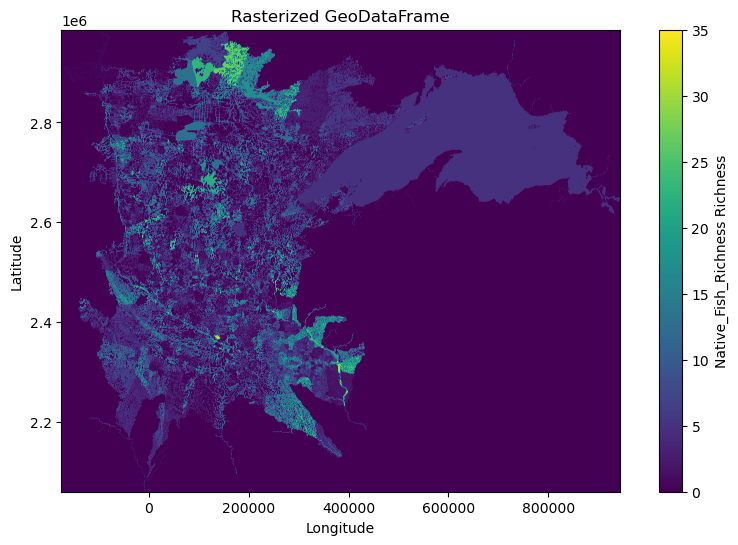

In [31]:
#fish_gdf = gpd.read_file(my_path + 'usgs_native_fish_rich.shp').to_crs(my_crs)
state_boundary = gpd.read_file(my_path + 'tl_2012_us_state.shp').dropna().to_crs(my_crs)
state = state_boundary[state_boundary['STUSPS'] == my_training_state].to_crs(my_crs)
buffered_water = gpd.read_file(my_path + my_training_state + '_buffered_water_dissolved.shp').to_crs(my_crs)
# Clip the points by the polygon
clipped_native_fish = clip_points_by_polygon(fish_gdf, state)
native_fish_gdf = sum_numeric_columns(clipped_native_fish)
water_w_native_fish = spatial_join_with_nearest(buffered_water, native_fish_gdf)
for col in water_w_native_fish.select_dtypes(include=['int64']).columns:
    water_w_native_fish[col] = water_w_native_fish[col].astype('float64')
export_native_raster(water_w_native_fish)

In [ ]:
# ---- Inputs & Settings ----
stream_paths = my_path + my_training_state + "_streams.shp"
presence_path = my_path + my_training_state + "_" + nas_name + "_nas.shp"
big_value = 9999999
streams = gpd.read_file(stream_paths).to_crs(my_crs)
streams = streams.drop_duplicates(subset='geometry').reset_index(drop=True)
dissolved = union_all(streams.geometry)
streams_all = gpd.GeoDataFrame(geometry=[dissolved], crs=streams.crs).explode(index_parts=False).reset_index(drop=True)
presence_all = gpd.read_file(presence_path).to_crs(my_crs)
# Simplify stream geometries with a 1000-meter tolerance
simplify_tolerance = 1000  # meters
streams_all["geometry"] = streams_all.simplify(tolerance=simplify_tolerance, preserve_topology=True)
streams_all.to_file(my_path +"streams_simplified.shp")

In [ ]:
@contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_callback
        tqdm_object.close()
def build_network(streams_gdf):
    G = nx.Graph()
    for geom in streams_gdf.geometry:
        if geom is None or geom.is_empty:
            continue
        if isinstance(geom, LineString):
            coords = list(geom.coords)
            edges = zip(coords[:-1], coords[1:])
        elif isinstance(geom, MultiLineString):
            edges = []
            for line in geom:
                coords = list(line.coords)
                edges.extend(zip(coords[:-1], coords[1:]))
        else:
            continue
        for u, v in edges:
            u_r = (round(u[0], 6), round(u[1], 6))
            v_r = (round(v[0], 6), round(v[1], 6))
            G.add_edge(u_r, v_r, weight=Point(u_r).distance(Point(v_r)))
    return G

def snap_points_to_vertices(points_gdf, vertices_tree, vertices_coords):
    coords = np.array([(geom.x, geom.y) for geom in points_gdf.geometry])
    _, idxs = vertices_tree.query(coords, k=1)
    snapped_points = vertices_coords[idxs]
    return snapped_points, idxs
def calculate_dijkstra_for_point(source_node, G, vertices_in_buffer):
    try:
        lengths = nx.single_source_dijkstra_path_length(G, source_node, weight='weight')
    except nx.NodeNotFound:
        return np.full(len(vertices_in_buffer), big_value, dtype=np.float32)

    vertex_distances = np.full(len(vertices_in_buffer), big_value, dtype=np.float32)
    for j, target_geom in enumerate(vertices_in_buffer.geometry):
        target_node = (round(target_geom.x, 6), round(target_geom.y, 6))
        if target_node in lengths:
            vertex_distances[j] = lengths[target_node]
    return vertex_distances
# --- Main Processing Function ---
def process_state(state_abbr, streams_all, presence_all):
    print(f"\n--- Processing {state_abbr} ---")
    shp_dir = os.path.join(my_path, f"{state_abbr}_vertex_distances")
    os.makedirs(shp_dir, exist_ok=True)
    shp_path = os.path.join(my_path, f"{state_abbr}_vertex_distances.shp")

    try:
        if streams_all.empty:
            print(f"Skipping {state_abbr}: no streams found.")
            return None

        streams = streams_all.copy()
        presence_points = presence_all
        if presence_points.crs is None:
            presence_points.set_crs(out_crs, inplace=True)
        if presence_points.empty:
            print(f"{state_abbr}: no presence points found in state. Skipping.")
            return None

        print(f"Extracting vertices for {state_abbr}...")
        all_vertices = []
        for geom in tqdm(streams.geometry, desc=f"{state_abbr} stream vertices", unit="geom"):
            if geom is None or geom.is_empty:
                continue
            if isinstance(geom, LineString):
                all_vertices.extend(geom.coords)
            elif isinstance(geom, MultiLineString):
                for line in geom.geoms:
                    all_vertices.extend(line.coords)

        vertices_gdf = gpd.GeoDataFrame(
            geometry=gpd.points_from_xy(
                [pt[0] for pt in all_vertices],
                [pt[1] for pt in all_vertices]
            ),
            crs=streams.crs
        ).drop_duplicates()

        vertices_gdf = vertices_gdf[~((vertices_gdf.geometry.x == 0) & (vertices_gdf.geometry.y == 0))]

        vertices_coords = np.array([(pt.x, pt.y) for pt in vertices_gdf.geometry])
        vertices_tree = cKDTree(vertices_coords)

        G = build_network(streams)
        print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

        snapped_coords, _ = snap_points_to_vertices(presence_points, vertices_tree, vertices_coords)
        snapped_coords = np.round(snapped_coords, 6)

        def is_node_in_graph(geom):
            return (round(geom.x, 6), round(geom.y, 6)) in G

        vertices_in_graph = vertices_gdf[vertices_gdf.geometry.apply(is_node_in_graph)]

        if vertices_in_graph.empty:
            print(f"{state_abbr}: no stream vertices found in graph. Skipping.")
            return None

        print(f"Running parallel Dijkstra for {len(snapped_coords)} presence-adjacent points in {state_abbr}...")

        presence_tree = cKDTree(snapped_coords)
        vertex_coords = np.array([(geom.x, geom.y) for geom in vertices_in_graph.geometry])
        _, nearest_presence_idxs = presence_tree.query(vertex_coords, k=1)

        presence_to_vertices = defaultdict(list)
        for v_idx, p_idx in enumerate(nearest_presence_idxs):
            presence_to_vertices[p_idx].append(v_idx)

        print(f"Running optimized Dijkstra for {len(presence_to_vertices)} unique presence points in {state_abbr}...")

        min_distances = np.full(len(vertices_in_graph), big_value, dtype=np.float32)

        with tqdm_joblib(tqdm(desc=f"{state_abbr} Dijkstra", total=len(presence_to_vertices), unit="pt")):
            results = Parallel(n_jobs=2, backend="threading")(
                delayed(calculate_dijkstra_for_point)(
                    tuple(snapped_coords[p_idx]), 
                    G, 
                    vertices_in_graph.iloc[v_idxs]
                )
                for p_idx, v_idxs in presence_to_vertices.items()
            )

        for (p_idx, v_idxs), dist_array in zip(presence_to_vertices.items(), results):
            for local_idx, global_idx in enumerate(v_idxs):
                min_distances[global_idx] = min(min_distances[global_idx], dist_array[local_idx])

        vertices_in_graph["distance_r"] = min_distances.astype(np.float32)

        vertices_in_graph.to_file(shp_path)
        print(f"{state_abbr} vertex shapefile exported to: {shp_path}")
        return shp_path

    except Exception as e:
        print(f"Error in {state_abbr}: {e}")
        return None
# Cell 2: Utility functions

def safe_read_file(fp):
    try:
        return gpd.read_file(fp)
    except Exception as e:
        raise IOError(f"Error reading {fp}: {e}")

def build_kdtree(vertices):
    coords = np.array(list(zip(vertices.geometry.x, vertices.geometry.y)))
    tree = cKDTree(coords)
    return tree, coords

def query_parallel(tree, points, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs, backend="threading")(
        delayed(tree.query)(pt) for pt in tqdm(points, desc="Querying KDTree", unit="pt")
    )
    return zip(*results)

def add_line_ids(stream_lines):
    stream_lines['line_id'] = stream_lines.index.astype(str)
    return stream_lines

def assign_vertices_to_lines(vertices, stream_lines):
    assert vertices.crs == stream_lines.crs, "CRS mismatch between vertices and stream lines"
    print("Assigning vertices to stream lines via spatial join...")
    joined = gpd.sjoin(vertices, stream_lines[['line_id', 'geometry']], how='left', predicate='within')
    if joined['line_id'].isna().all():
        raise ValueError("No vertices could be matched to stream lines. Check geometries.")
    return joined

def filter_disconnected_lines(vertices):
    print("Filtering disconnected stream segments...")
    bad_line_ids = (
        vertices.groupby('line_id')['distance_r']
        .apply(lambda x: (x == 9999999).all())
        .loc[lambda x: x].index
    )
    return bad_line_ids

def split_waterbodies_by_connection(waterbodies, stream_lines, bad_line_ids):
    print("Splitting waterbodies into connected and disconnected sets...")
    disconnected = stream_lines[stream_lines['line_id'].isin(bad_line_ids)]
    connected = stream_lines[~stream_lines['line_id'].isin(bad_line_ids)]
    waterbodies = waterbodies.to_crs(stream_lines.crs)
    wb_disconnected = gpd.sjoin(waterbodies, disconnected, how='inner', predicate='intersects')
    wb_connected = gpd.sjoin(waterbodies, connected, how='inner', predicate='intersects')
    wb_disconnected_ids = set(wb_disconnected.index)
    wb_connected_ids = set(wb_connected.index)
    purely_disconnected_ids = wb_disconnected_ids - wb_connected_ids
    return (
        waterbodies[~waterbodies.index.isin(purely_disconnected_ids)],
        waterbodies[waterbodies.index.isin(purely_disconnected_ids)]
    )
# Cell 3: Rasterization and plotting
def rasterize_distances(vertices, waterbodies_connected, waterbodies_disconnected, output_raster_fp, pixel_size=30):
    print("Rasterizing distances to source...")
    vertices = vertices[vertices['distance_r'].notna()]
    vertices = vertices[vertices['distance_r'] != 9999999]
    vertices['distance_r'] = vertices['distance_r'].astype(float)

    tree, coords = build_kdtree(vertices)
    values = vertices['distance_r'].values

    all_waterbodies = gpd.GeoSeries(pd.concat([waterbodies_connected.geometry, waterbodies_disconnected.geometry]))
    minx, miny, maxx, maxy = all_waterbodies.total_bounds
    width = int(np.ceil((maxx - minx) / pixel_size))
    height = int(np.ceil((maxy - miny) / pixel_size))
    transform = from_bounds(minx, miny, maxx, maxy, width, height)

    x_coords = np.linspace(minx + pixel_size / 2, maxx - pixel_size / 2, width)
    y_coords = np.linspace(maxy - pixel_size / 2, miny + pixel_size / 2, height)
    xx, yy = np.meshgrid(x_coords, y_coords)
    pixel_points = np.c_[xx.ravel(), yy.ravel()]

    print("Rasterizing waterbody masks...")
    all_waterbody_mask = rasterize(
        [(geom, 1) for geom in all_waterbodies],
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype='uint8'
    )
    connected_mask = rasterize(
        [(geom, 1) for geom in waterbodies_connected.geometry],
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype='uint8'
    )

    output_array = np.full((height, width), 9999999, dtype='float32')
    idx_connected = np.where(connected_mask.ravel() == 1)[0]

    print(f"Querying {len(idx_connected)} connected pixels to KDTree...")
    dist, nn_idx = query_parallel(tree, list(pixel_points[idx_connected]))
    output_array.ravel()[idx_connected] = values[list(nn_idx)]
    output_array[all_waterbody_mask == 0] = np.nan

    valid_mask = output_array != 9999999
    if np.any(valid_mask):
        max_val = np.nanmax(output_array[valid_mask])
        output_array[~valid_mask] = max_val
    else:
        print("Warning: No valid distances found. Raster may be empty.")

    print(f"Writing output raster to {output_raster_fp}...")
    with rasterio.open(
        output_raster_fp,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype='float32',
        crs=waterbodies_connected.crs,
        transform=transform,
        nodata=np.nan
    ) as dst:
        dst.write(output_array, 1)

    return output_array

def preview_raster(array):
    plt.imshow(array, cmap='viridis')
    plt.colorbar(label='Distance to Source')
    plt.title('Rasterized Distance to Stream Source')
    plt.show()

def log_metadata(output_fp, metadata_dict):
    print(f"Logging metadata to {output_fp}...")
    with open(output_fp, 'w') as f:
        json.dump(metadata_dict, f, indent=2)

# --- Run Processing for MN ---
output_zip = process_state("MN", streams_all, presence_all)
print("\n✅ Done.")

# Cell 4: Setup inputs and run
state = "MN"  # <-- Change this
pixel_size = 100
preview = True

base_dir = os.getcwd()
streams_fp = os.path.join(my_path, f'streams_simplified.shp')
vertices_fp = os.path.join(my_path, f'{state}_vertex_distances.shp')
waterbodies_fp = os.path.join(my_path, f'{state}_buffered_water_dissolved.shp')
output_raster_fp = os.path.join(my_path, f'{state}_dist_to_src_river.tif')
metadata_fp = output_raster_fp.replace('.tif', '_metadata.json')

os.makedirs(os.path.dirname(output_raster_fp), exist_ok=True)

print("Reading data...")
streams = add_line_ids(safe_read_file(streams_fp))
vertices = safe_read_file(vertices_fp)
waterbodies = safe_read_file(waterbodies_fp)

vertices = assign_vertices_to_lines(vertices.to_crs(streams.crs), streams)
bad_line_ids = filter_disconnected_lines(vertices)
wb_connected, wb_disconnected = split_waterbodies_by_connection(waterbodies, streams, bad_line_ids)

raster_arr = rasterize_distances(vertices, wb_connected, wb_disconnected, output_raster_fp, pixel_size)

log_metadata(metadata_fp, {
    'state': state,
    'pixel_size': pixel_size,
    'bad_line_ids': list(bad_line_ids),
    'vertex_count': len(vertices),
    'raster_output': output_raster_fp
})

if preview:
    preview_raster(raster_arr)


In [ ]:
# Road Distance

In [ ]:
# Download road shapefile
road_url = f'https://www2.census.gov/geo/tiger/TIGER2022/PRISECROADS/tl_2022_{state_fips}_prisecroads.zip'
local_path = my_path
print('Downloading shapefile...')
r = requests.get(road_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")
z.extractall(path=local_path) # extract to folder
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)

In [ ]:
#Download USGS boat access data 
# URL of the compressed file containing multiple files
URL_BASE = "https://www.sciencebase.gov/catalog/file/get/63b81b50d34e92aad3cc004d?facet=Boatramps_United_States_final_20230104"
desired_extensions = {'.dbf', '.prj', '.shp', '.shx'}  # Use set for faster membership testing

def download_and_extract_selected_files(url, out_dir, extensions):
    try:
        response = requests.get(url, stream=True, timeout=60)
        response.raise_for_status()  # Raise HTTPError for bad responses

        with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
            os.makedirs(out_dir, exist_ok=True)
            selected_files = [f for f in zip_ref.namelist() if os.path.splitext(f)[1].lower() in extensions]

            if not selected_files:
                print("No matching files found in the ZIP archive.")
                return

            for file_name in selected_files:
                zip_ref.extract(file_name, out_dir)
                print(f"Extracted: {file_name}")

            print(f"Selected files extracted to: {out_dir}")

    except requests.RequestException as e:
        print(f"Request failed: {e}")
    except zipfile.BadZipFile:
        print("Downloaded file is not a valid ZIP archive.")

download_and_extract_selected_files(URL_BASE, my_path, desired_extensions)

In [ ]:
def nas_api_call_2(nas_id, state):
    URL_BASE = 'http://nas.er.usgs.gov/api/v2/'
    url_request = f"{URL_BASE}/occurrence/search?species_ID={nas_id}&state={my_training_state}"
    response = requests.get(url_request, timeout=None).json()
    results = pd.json_normalize(response, 'results')
    return results

# Function to get the endpoints of a line geometry
def get_endpoints(geometry):
    # Ensure the geometry is a LineString
    if geometry.geom_type == 'LineString':
        # Get the first and last coordinate of the line
        return [geometry.coords[0], geometry.coords[-1]]
    return []

def snap_points_to_nearest_poly(poly: gpd.GeoDataFrame, point: gpd.GeoDataFrame, snapdist: float) -> gpd.GeoDataFrame:
    """
    Snaps points to the nearest polygon within a given distance.
    
    Parameters:
        poly (GeoDataFrame): GeoDataFrame containing polygon geometries.
        point (GeoDataFrame): GeoDataFrame containing point geometries.
        snapdist (float): Maximum search distance to find the nearest polygon.
    
    Returns:
        GeoDataFrame: Updated point GeoDataFrame with snapped geometries.
    """
    # Ensure both datasets use the same projected CRS (Sweden EPSG:3006 in original, changed to 26915)
    poly = poly.to_crs(my_crs)
    point = point.set_crs(my_crs)
    
    # Create unique IDs
    poly["polyid"] = range(poly.shape[0])
    point["pointid"] = range(point.shape[0])
    
    # Store original polygon geometry
    poly["polygeom"] = poly.geometry
    
    # Perform spatial join to find nearest polygons within snap distance
    sj = gpd.sjoin_nearest(left_df=point, right_df=poly, how="left", max_distance=snapdist)
    
    # Measure distances (set to None if no polygon within snapdistance)
    sj["distance"] = sj.apply(lambda x: x.geometry.distance(x.polygeom) if x.polygeom is not None else None, axis=1)
    
    # Sort by distance and drop duplicates (keeping closest polygon match)
    sj = sj.sort_values(by=["pointid", "distance"], ascending=True, na_position="last")
    sj = sj.drop_duplicates(subset="pointid", keep="first")
    
    # Find the nearest point on the polygon
    sj["nearestpoint"] = sj.apply(
        lambda x: nearest_points(x.geometry, x.polygeom)[1] if (x.polygeom is not None and x.distance is not None) else None,
        axis=1
    )
    
    # Snap points to nearest point on polygon if applicable
    sj["geometry"] = sj.apply(
        lambda x: snap(x.geometry, x.nearestpoint, snapdist) if x.nearestpoint is not None else x.geometry,
        axis=1
    )
    
    return sj

def sjoin_nearest_to_centroid_replace_geom(left_gdf, right_gdf, **kwargs):
    """
    For each geometry in left_gdf, finds the nearest geometry in right_gdf
    to the centroid of the left geometry. Replaces left_gdf's geometry with
    the nearest right_gdf geometry. Keeps left_gdf attributes and adds 'epointID'
    and distance to the nearest point from right_gdf.

    Parameters:
    - left_gdf (GeoDataFrame): Attributes to keep; geometry to replace.
    - right_gdf (GeoDataFrame): Provides geometry and 'epointID' for replacement.
    - **kwargs: Additional arguments for gpd.sjoin_nearest (e.g., max_distance).

    Returns:
    - GeoDataFrame: Combined GeoDataFrame with left_gdf attributes,
      geometry from right_gdf, epointID, and distance.
    """
    # Step 1: Compute centroids of left geometries for matching
    left_centroids = left_gdf.copy()
    left_centroids["geometry_centroid"] = left_centroids.geometry.centroid
    left_centroids = left_centroids.set_geometry("geometry_centroid")

    # Step 2: Prepare right_gdf with renamed geometry
    right_temp = right_gdf.copy()
    right_temp["geometry_right"] = right_temp.geometry
    right_temp = right_temp.set_geometry("geometry_right")

    # Step 3: Perform nearest spatial join
    joined = gpd.sjoin_nearest(left_centroids, right_temp, how="left", **kwargs)

    # Step 4: Compute distances from centroids to matched right_gdf geometries
    joined["distance"] = joined.geometry_centroid.distance(joined["geometry_right"])

    # Step 5: Construct result: original left_gdf attributes + geometry from right_gdf
    result = left_gdf.copy()
    result["geometry"] = joined["geometry_right"]
    result["epointID"] = joined["epointID"]
    result["distance_to_nearest"] = joined["distance"]

    return result

In [ ]:
ramps = gpd.read_file(my_path + 'Boatramps_United_States_final_20230104.shp').set_crs(my_crs, allow_override=True)
ramp_geo = ramps.loc[ramps['State'] == state_name, ['geometry']].copy()
ramp_geo['ramp_ID'] = range(1, len(ramp_geo) + 1)
# Import buffered water
buffered_water = gpd.read_file(my_path + my_training_state + "_buffered_water.shp").set_crs(my_crs, allow_override = True)
# Get locations of your AIS. 
pos_data = nas_api_call_2(my_nas_id, my_training_state)
my_data = pos_data[["decimalLatitude", "decimalLongitude"]]
pos_data_gdf = gpd.GeoDataFrame(
    my_data, geometry=gpd.points_from_xy(my_data.decimalLongitude, my_data.decimalLatitude), crs="EPSG:4326"  # ← correct CRS for lat/lon
).to_crs(my_crs) 
# Identify positive and negative water
pos_water_check = buffered_water.sjoin(pos_data_gdf, how="left", predicate="contains")
pos_water_check = pos_water_check.drop_duplicates(subset="waterID", keep="first")
neg_water = pos_water_check[pos_water_check['index_right'].isna()].drop(columns=["index_right", "decimalLatitude", "decimalLongitude"], errors="ignore")
pos_water = pos_water_check.dropna(subset=["index_right"]).drop(columns=["index_right", "decimalLatitude", "decimalLongitude"], errors="ignore")
pos_water["Present"], neg_water["Present"] = 1.0, 0.0
water_w_present = pd.concat([pos_water, neg_water])
# Identify ramps that are within waterbodies and snap unjoinable ramps to the nearest waterbody within maximum distance.
ramps_in_water = ramp_geo.sjoin(water_w_present, how="left", predicate="within")
ramps_not_in_water = ramps_in_water[ramps_in_water['index_right'].isna()].drop(columns=["index_right"], errors="ignore").copy()
ramps_in_water = ramps_in_water.dropna(subset=["index_right"]).drop(columns=["index_right"], errors="ignore").set_crs(my_crs, allow_override = True)
ramps_in_water["waterID"] = ramps_in_water["waterID"].astype("int64")

In [ ]:
# Identify water without ramps; identify point on polygon perimeter closest to a road endpoint
water_w_ramps_list = ramps_in_water['waterID'].tolist()
water_no_ramps = water_w_present[~water_w_present['waterID'].isin(water_w_ramps_list)]
# Identify road endpoints; remove duplicates
my_roads = gpd.read_file(my_path + 'tl_2022_'+ state_fips +'_prisecroads.shp').to_crs(my_crs)
# Extract endpoints for all lines
endpoints = my_roads['geometry'].apply(get_endpoints).explode()
# Convert the list of endpoints to a DataFrame
endpoints_df = pd.DataFrame(endpoints.tolist(), columns=['x', 'y'])
# Remove duplicate points
endpoints_df = endpoints_df.drop_duplicates()
# Create a GeoDataFrame for the endpoints
endpoints_gdf = gpd.GeoDataFrame(endpoints_df, geometry=gpd.points_from_xy(endpoints_df['x'], endpoints_df['y'])).set_crs(my_crs, allow_override = True).drop(columns = ['x', 'y'])
endpoints_gdf['epointID'] = range(1, len(endpoints_gdf) + 1)
ramps_in_water_sj = sjoin_nearest_to_centroid_replace_geom(ramps_in_water, endpoints_gdf)
lakes_no_ramp_sj = sjoin_nearest_to_centroid_replace_geom(water_no_ramps, endpoints_gdf)
lakes_no_ramp_epoints = lakes_no_ramp_sj[['waterID', 'geometry', 'Present', 'epointID', 'distance_to_nearest']].dropna()
ramps_in_water_epoints = ramps_in_water_sj[['waterID', 'geometry', 'Present', 'epointID', 'distance_to_nearest']].dropna()
my_endpoints = pd.concat([ramps_in_water_epoints, lakes_no_ramp_epoints])
pos_endpoints = my_endpoints.loc[my_endpoints['Present'] == 1.0]
neg_endpoints = my_endpoints.loc[my_endpoints['Present'] == 0.0]

In [ ]:
def build_network_optimized(road_network_gdf, precision=6):
    """
    Build a NetworkX graph from a GeoDataFrame of road LineStrings.

    Nodes are rounded to a given precision to reduce floating-point redundancy.

    Args:
        road_network_gdf (GeoDataFrame): Must contain LineString or MultiLineString geometries.
        precision (int): Number of decimal places to round coordinates to for node deduplication.

    Returns:
        networkx.Graph: Graph with nodes as (x, y) tuples and edges weighted by length.
    """
    import networkx as nx
    from shapely.geometry import LineString

    G = nx.Graph()

    for geom in road_network_gdf.geometry:
        if geom is None:
            continue

        # Handle both LineString and MultiLineString
        if isinstance(geom, LineString):
            lines = [geom]
        elif hasattr(geom, 'geoms'):  # MultiLineString
            lines = list(geom.geoms)
        else:
            continue

        for line in lines:
            coords = list(line.coords)
            for u, v in zip(coords[:-1], coords[1:]):
                if len(u) < 2 or len(v) < 2:
                    continue  # skip invalid coordinate pairs

                u_rounded = tuple(round(c, precision) for c in u[:2])
                v_rounded = tuple(round(c, precision) for c in v[:2])
                dist = LineString([u, v]).length

                # Add undirected edge with distance as weight
                G.add_edge(u_rounded, v_rounded, weight=dist)

    return G


In [ ]:
from scipy.spatial import cKDTree

def build_nearest_node_index(graph):
    """
    Build a KDTree for efficient nearest-node lookup in a NetworkX graph.

    Args:
        graph (networkx.Graph): A graph with 2D tuple coordinates as nodes.

    Returns:
        cKDTree: KD-tree built from graph node coordinates.
        list: List of node tuples in the same order as the KD-tree.
    """
    # Ensure all nodes are 2D points (x, y)
    nodes = [node for node in graph.nodes if len(node) == 2]
    coords = [list(node) for node in nodes]  # convert tuples to lists for KDTree

    tree = cKDTree(coords)
    return tree, nodes
def find_nearest_node_kd_tree(kd_tree, point, precision=6):
    """
    Find the nearest graph node to a given point using a KD-tree.

    Args:
        kd_tree (cKDTree): KDTree built from graph node coordinates.
        point (shapely.geometry.Point): Point to find the nearest node to.
        precision (int): Decimal places to round the coordinates.

    Returns:
        tuple: The (x, y) coordinates of the nearest node, rounded.
    """
    _, index = kd_tree.query([point.x, point.y])
    nearest_coords = kd_tree.data[index]
    return tuple(round(coord, precision) for coord in nearest_coords)
def assign_endpoints_multi_source_dijkstra(presences_gdf, endpoints_gdf, G, kd_tree, precision=6):
    """
    Assign each endpoint to its nearest presence based on road network distance.

    Args:
        presences_gdf (GeoDataFrame): GeoDataFrame of presence points with 'epointID'.
        endpoints_gdf (GeoDataFrame): GeoDataFrame of negative endpoints with 'epointID'.
        G (networkx.Graph): Graph of road network.
        kd_tree (cKDTree): KDTree built from graph nodes.
        precision (int): Decimal precision for rounding coordinates.

    Returns:
        List[dict]: Each dict contains 'epointID', 'target_point_id', and 'distance_roads'.
    """
    # Step 1: Snap presence points to graph nodes
    presence_nodes = {}
    node_to_presence_id = {}

    for _, row in tqdm(presences_gdf.iterrows(), total=len(presences_gdf), desc="Snapping presences"):
        node = find_nearest_node_kd_tree(kd_tree, row.geometry.centroid, precision)
        if not G.has_node(node):
            continue  # Skip if the node isn't actually in the graph
        presence_nodes[row["epointID"]] = node
        node_to_presence_id[node] = row["epointID"]

    if not presence_nodes:
        raise ValueError("No presence points could be snapped to graph nodes.")

    # Step 2: Multi-source Dijkstra from all presence nodes
    source_nodes = list(presence_nodes.values())
    distances, predecessors = nx.multi_source_dijkstra(G, sources=source_nodes, weight='weight')

    # Step 3: For each negative endpoint, find the closest presence
    results = []

    for _, row in tqdm(endpoints_gdf.iterrows(), total=len(endpoints_gdf), desc="Processing negatives"):
        neg_id = row["epointID"]
        neg_point = row.geometry.centroid
        neg_node = find_nearest_node_kd_tree(kd_tree, neg_point, precision)

        if not G.has_node(neg_node):
            results.append({
                "epointID": neg_id,
                "target_point_id": None,
                "distance_roads": np.inf
            })
            continue

        if neg_node in source_nodes:
            # Direct match to a presence node
            dist = 0.0
            target_id = node_to_presence_id[neg_node]
        elif neg_node in distances:
            # Trace back the path to the nearest source
            path = []
            current = neg_node
            while current not in source_nodes:
                prev = predecessors.get(current)
                if not prev:
                    break
                current = prev[0]  # Multi-source returns list of predecessors
                path.append(current)

            source_node = current if current in source_nodes else None
            target_id = node_to_presence_id.get(source_node, None)
            dist = distances[neg_node]
        else:
            # Not reachable
            dist = np.inf
            target_id = None

        results.append({
            "epointID": neg_id,
            "target_point_id": target_id,
            "distance_roads": dist
        })

    return results
def vector_to_raster(gdf, out_tif, value_field=None, resolution=100):
    # Ensure geometries are valid
    gdf = gdf[~gdf.geometry.isna()]
    gdf = gdf[gdf.geometry.is_valid]

    # Ensure it has a CRS
    if gdf.crs is None:
        raise ValueError("GeoDataFrame must have a CRS.")

    # Reproject to projected CRS if necessary
    if gdf.crs.is_geographic:
        gdf = gdf.to_crs("EPSG:5070")  # NAD83 / Conus Albers (meters)

    # Get bounds
    minx, miny, maxx, maxy = gdf.total_bounds
    width = int(np.ceil((maxx - minx) / resolution))
    height = int(np.ceil((maxy - miny) / resolution))

    # Check again
    if width <= 0 or height <= 0:
        raise ValueError("Calculated width or height is <= 0. Check your resolution and geometry bounds.")

    # Create transform
    transform = from_origin(minx, maxy, resolution, resolution)

    # Prepare shapes
    shapes = (
        ((geom, value) for geom, value in zip(gdf.geometry, gdf[value_field]))
        if value_field else
        ((geom, 1) for geom in gdf.geometry)
    )

    # Rasterize
    raster = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill= np.nan,
        dtype='float32' if not value_field else 'float32'
    )

    # Write to GeoTIFF
    with rasterio.open(
        out_tif,
        "w",
        driver="GTiff",
        height=height,
        width=width,
        count=1,
        dtype=raster.dtype,
        crs=gdf.crs,
        transform=transform,
    ) as dst:
        dst.write(raster, 1)

    print(f"Raster written to {out_tif}")

In [ ]:
# CRS alignment
my_roads = my_roads.to_crs(my_crs)
pos_endpoints = pos_endpoints.to_crs(my_crs)
neg_endpoints = neg_endpoints.to_crs(my_crs)

# Build the graph and KDTree
G = build_network_optimized(my_roads)
kd_tree, graph_nodes = build_nearest_node_index(G)

In [ ]:
# Run the updated function
dijkstra_results = assign_endpoints_multi_source_dijkstra(
    presences_gdf=pos_endpoints,
    endpoints_gdf=neg_endpoints,
    G=G,
    kd_tree=kd_tree,
    precision=6
)

In [ ]:
dist_df = pd.DataFrame(dijkstra_results)
# Replace inf/-inf in dist_df['distance_roads'] with a large finite number (adjust if needed)
dist_df = dist_df.loc[dist_df.groupby('epointID')['distance_roads'].idxmin()].reset_index(drop=True)

# Join distances to ramp and lake endpoints
ramps_w_dist = pd.merge(ramps_in_water_epoints, dist_df, on='epointID', how='left')
lakes_no_ramp_w_dist = pd.merge(lakes_no_ramp_epoints, dist_df, on='epointID', how='left')

# Select and clean needed columns
keep_cols = ['geometry', 'target_point_id', 'epointID', 'waterID', 'Present', 'distance_roads', 'distance_to_nearest']
ramps_w_dist_clean = ramps_w_dist[keep_cols].dropna()
lakes_no_ramp_w_dist_clean = lakes_no_ramp_w_dist[keep_cols].dropna()

# Downcast numeric columns to save memory
for df in [ramps_w_dist_clean, lakes_no_ramp_w_dist_clean]:
    for col in ['distance_roads', 'distance_to_nearest']:
        df[col] = pd.to_numeric(df[col], downcast='float')

# Create adjusted column (copy distance_to_nearest)
ramps_w_dist_clean['adjusted_distance_to_nearest'] = ramps_w_dist_clean['distance_to_nearest']
lakes_no_ramp_w_dist_clean['adjusted_distance_to_nearest'] = lakes_no_ramp_w_dist_clean['distance_to_nearest']

# Pre-fill missing distances
ramps_w_dist_clean['distance_roads_filled'] = ramps_w_dist_clean['distance_roads'].fillna(0)
lakes_no_ramp_w_dist_clean['distance_roads_filled'] = lakes_no_ramp_w_dist_clean['distance_roads'].fillna(0)

# Compute distance_roads_total in two safe steps
# For ramps
ramps_w_dist_clean['distance_roads_total'] = 0
ramps_w_dist_clean.loc[ramps_w_dist_clean['Present'] == 0, 'distance_roads_total'] = (
    ramps_w_dist_clean['distance_roads'] + ramps_w_dist_clean['adjusted_distance_to_nearest']
)
ramps_w_dist_clean.loc[ramps_w_dist_clean['Present'] != 0, 'distance_roads_total'] = (
    ramps_w_dist_clean['distance_roads_filled']
)

# For lakes
lakes_no_ramp_w_dist_clean['distance_roads_total'] = 0
lakes_no_ramp_w_dist_clean.loc[lakes_no_ramp_w_dist_clean['Present'] == 0, 'distance_roads_total'] = (
    lakes_no_ramp_w_dist_clean['distance_roads'] + lakes_no_ramp_w_dist_clean['adjusted_distance_to_nearest']
)
lakes_no_ramp_w_dist_clean.loc[lakes_no_ramp_w_dist_clean['Present'] != 0, 'distance_roads_total'] = (
    lakes_no_ramp_w_dist_clean['distance_roads_filled']
)

# Optional: drop intermediate columns to free memory
ramps_w_dist_clean.drop(columns=['distance_roads_filled'], inplace=True)
lakes_no_ramp_w_dist_clean.drop(columns=['distance_roads_filled'], inplace=True)

# Final concatenation
final_dist_df = pd.concat([ramps_w_dist_clean, lakes_no_ramp_w_dist_clean], ignore_index=True)

In [ ]:
# Identify shortest distance by waterID
min_dist_to_source = final_dist_df.loc[final_dist_df.groupby("waterID")["distance_roads_total"].idxmin()]
# Join back to waterbody shapefile and convert to raster
water_w_dist = pd.merge(buffered_water, min_dist_to_source, on = 'waterID', how = 'left')
water_w_dist_final = water_w_dist[["waterID", "geometry_x", "distance_roads_total"]].rename(columns ={"geometry_x": "geometry"}).dropna()

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot with colors representing 'distance_roads'
water_w_dist_final.plot(
    ax=ax, column="distance_roads_total", cmap="viridis", linewidth=0.5, legend=True
)

# Set titles and labels
ax.set_title("Water with Distance to Roads", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [ ]:
output_filename = f"{my_path}{my_training_state}_{'road_distance'}_{nas_name}.tif"
vector_to_raster(water_w_dist_final, output_filename, value_field="distance_roads_total", resolution=100)

In [32]:
def combine_geotiffs(input_files, output_file, state=None):
    """
    Combine single-band GeoTIFFs into a multi-band GeoTIFF.

    Parameters:
        input_files (list): List of input raster file paths.
        output_file (str): Path to output multi-band GeoTIFF.
        state (str): Optional metadata tag (not used in core logic but kept for compatibility).
    """
    sources = []
    meta = None

    for i, file in enumerate(input_files):
        try:
            src = rasterio.open(file)
            if meta is None:
                meta = src.meta.copy()
                meta.update({
                    'count': len(input_files),
                    'dtype': src.dtypes[0]
                })
            sources.append(src.read(1))  # Read first (and only) band
            src.close()
        except RasterioIOError:
            print(f"⚠️ Warning: Could not read {file}, skipping...")
            sources.append(np.full_like(sources[0], np.nan))  # Placeholder if desired

    if meta is None:
        raise RuntimeError("❌ No valid input rasters found.")

    with rasterio.open(output_file, 'w', **meta) as dst:
        for idx, array in enumerate(sources, start=1):
            dst.write(array, idx)


In [38]:
import rasterio
from rasterio.errors import RasterioIOError
import numpy as np

def combine_geotiffs(input_files, output_file, state=None):
    """
    Combine single- or multi-band GeoTIFFs into one multi-band GeoTIFF,
    preserving band names where available.

    Parameters:
        input_files (list): List of input raster file paths.
        output_file (str): Path to output multi-band GeoTIFF.
        state (str): Optional metadata tag (not used in core logic).
    """
    all_bands = []
    band_descriptions = []
    meta = None

    for file in input_files:
        try:
            with rasterio.open(file) as src:
                if meta is None:
                    meta = src.meta.copy()
                    meta.update({
                        'count': 0,  # Will be updated after reading all bands
                        'dtype': src.dtypes[0]  # Assumes consistent dtype
                    })

                for bidx in range(1, src.count + 1):
                    band_data = src.read(bidx)
                    all_bands.append(band_data)

                    # Try to get band description (e.g., band name)
                    desc = src.descriptions[bidx - 1] or f'band_{bidx}'
                    band_descriptions.append(desc)

        except RasterioIOError:
            print(f"⚠️ Warning: Could not read {file}, skipping...")

    if not all_bands:
        raise RuntimeError("❌ No valid input rasters found.")

    meta['count'] = len(all_bands)

    with rasterio.open(output_file, 'w', **meta) as dst:
        for idx, band in enumerate(all_bands, start=1):
            dst.write(band, idx)
            if band_descriptions[idx - 1]:
                dst.set_band_description(idx, band_descriptions[idx - 1])


In [39]:
# Combine all the predictors you just created and export a final combined raster 
# Define input files
input_files = [
    my_path + my_training_state + "_ca.tif", my_path + my_training_state + "_pH.tif", my_path + my_training_state + "_di_N.tif",
    my_path + my_training_state + "_do.tif", my_path + my_training_state + "_phos.tif", my_path + my_training_state + "_inv_richness.tif", 
    my_path + my_training_state + "_Native_Fish_Richness.tif",
    my_path + my_training_state + '_road_distance_' + nas_name + '.tif', my_path + 'MN_dist_to_src_river.tif',
    my_path + my_training_state + '_rsd.tif']
#Combine rasters into a multi-band GeoTIFF
output_file = my_path + my_training_state + "_combined.tif" # this will replace the other combined tif you made.
combine_geotiffs(input_files, output_file, state)

print(f"✅ Multi-band raster saved as {output_file}")

✅ Multi-band raster saved as data/MN/MN_combined.tif
